# Test plane-based registration

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os

import planeslam.io as io
from planeslam.general import plot_3D_setup, color_legend
from planeslam.scan import pc_to_scan
from planeslam.registration import extract_corresponding_features

%load_ext autoreload
%autoreload 2

Read in airsim LiDAR and pose data

In [2]:
# Read in point cloud data
binpath = os.path.join(os.getcwd(), '..', '..', 'data', 'airsim', 'blocks_20_samples_1', 'lidar', 'Drone0')
PC_data = io.read_lidar_bin(binpath)

In [3]:
# Read in ground-truth poses (in drone local frame)
posepath = os.path.join(os.getcwd(), '..', '..', 'data', 'airsim', 'blocks_20_samples_1', 'poses', 'Drone0')
drone_positions, drone_orientations = io.read_poses(posepath)

Extract planes 

In [4]:
num_scans = len(PC_data)
scans = num_scans * [None]
scans_transformed = num_scans * [None]
for i in range(num_scans):
    scans[i] = pc_to_scan(PC_data[i])

In [5]:
# ax = plot_3D_setup(PC_data[0])
# cmap = cm.get_cmap('viridis')
# cmap_idxs = int(len(cmap.colors) / num_scans) * np.arange(num_scans)
# colors = np.asarray(cmap.colors)[cmap_idxs,:]

# for i, s in enumerate(scans):
#     s.plot(ax, color=colors[i])

Get correspondences

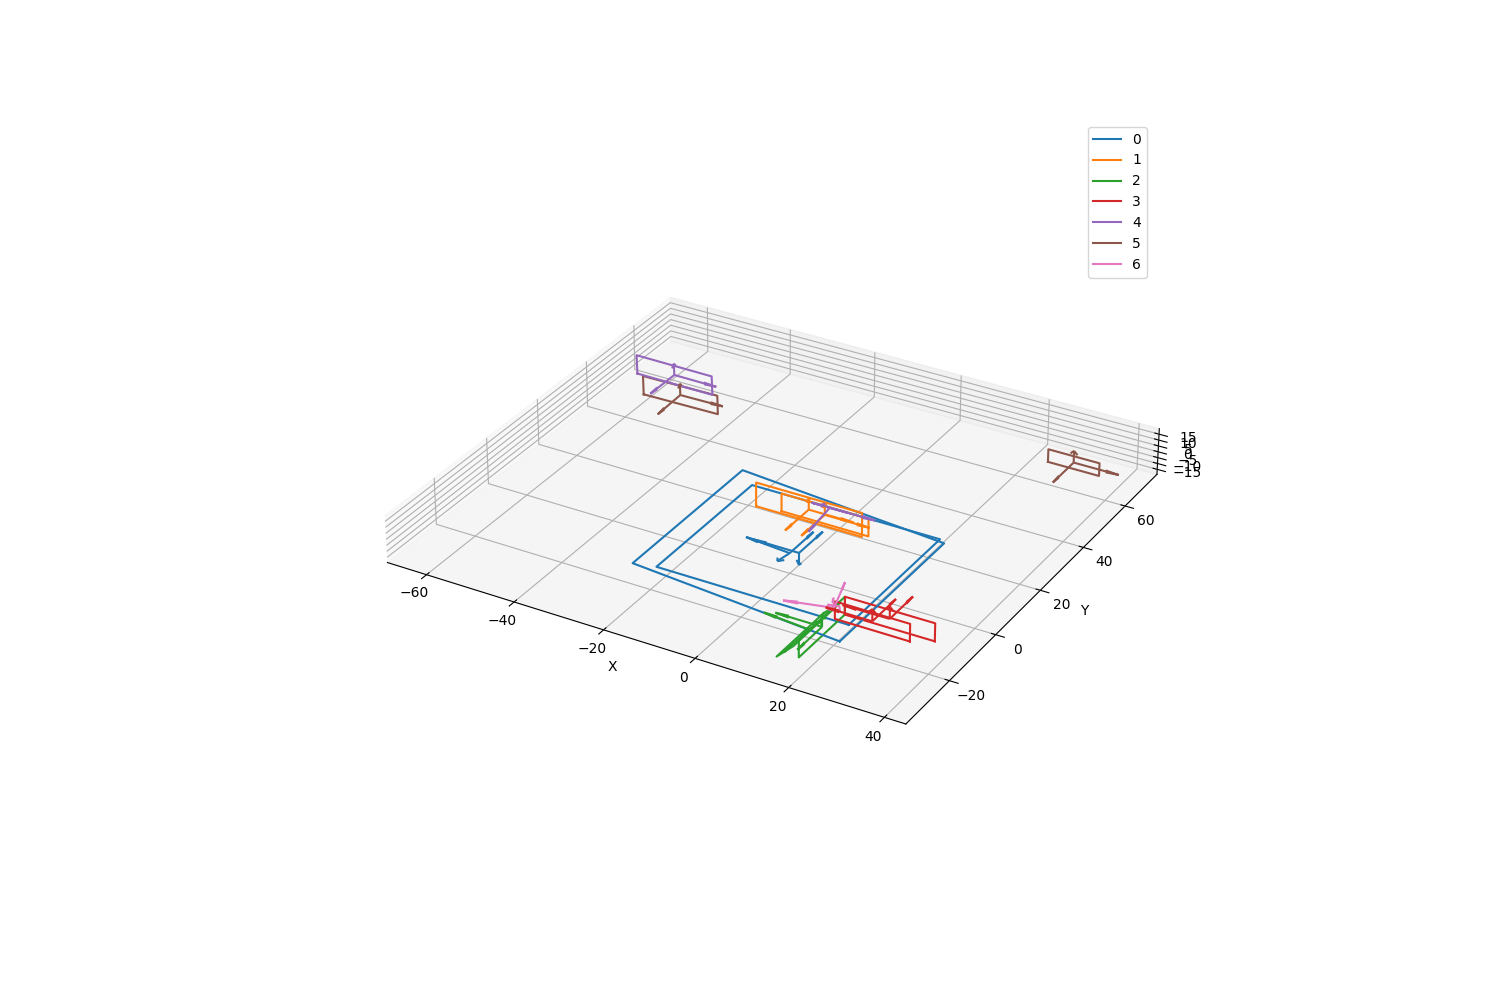

In [6]:
# Plot first 2 scans
ax = plot_3D_setup(PC_data[0])
for i, scan in enumerate(scans[0:2]):
    scan.plot(ax, show_normals=True)

# Color legend
num_colors = max([len(s.planes) for s in scans[0:2]])
color_legend(ax, num_colors)

In [7]:
# Extract normals and distances
n_s, d_s, n_t, d_t = extract_corresponding_features(scans[0], scans[1])

Test registration

Test with single plane

In [17]:
from planeslam.geometry.plane import BoundedPlane
from scipy.spatial.transform import Rotation

import copy

V = np.array([[-1, 1, -1],
              [1, 1, -1],
              [1, 1, 1],
              [-1, 1, 1]])
P = BoundedPlane(V)

# Ground-truth transformation
t = np.array([0, 0, 0])[:,None]
r = Rotation.from_euler('xyz',[20, 45, 0], degrees=True)

R = r.as_matrix()

In [18]:
Q = copy.copy(P)
Q.transform(R, t.flatten())

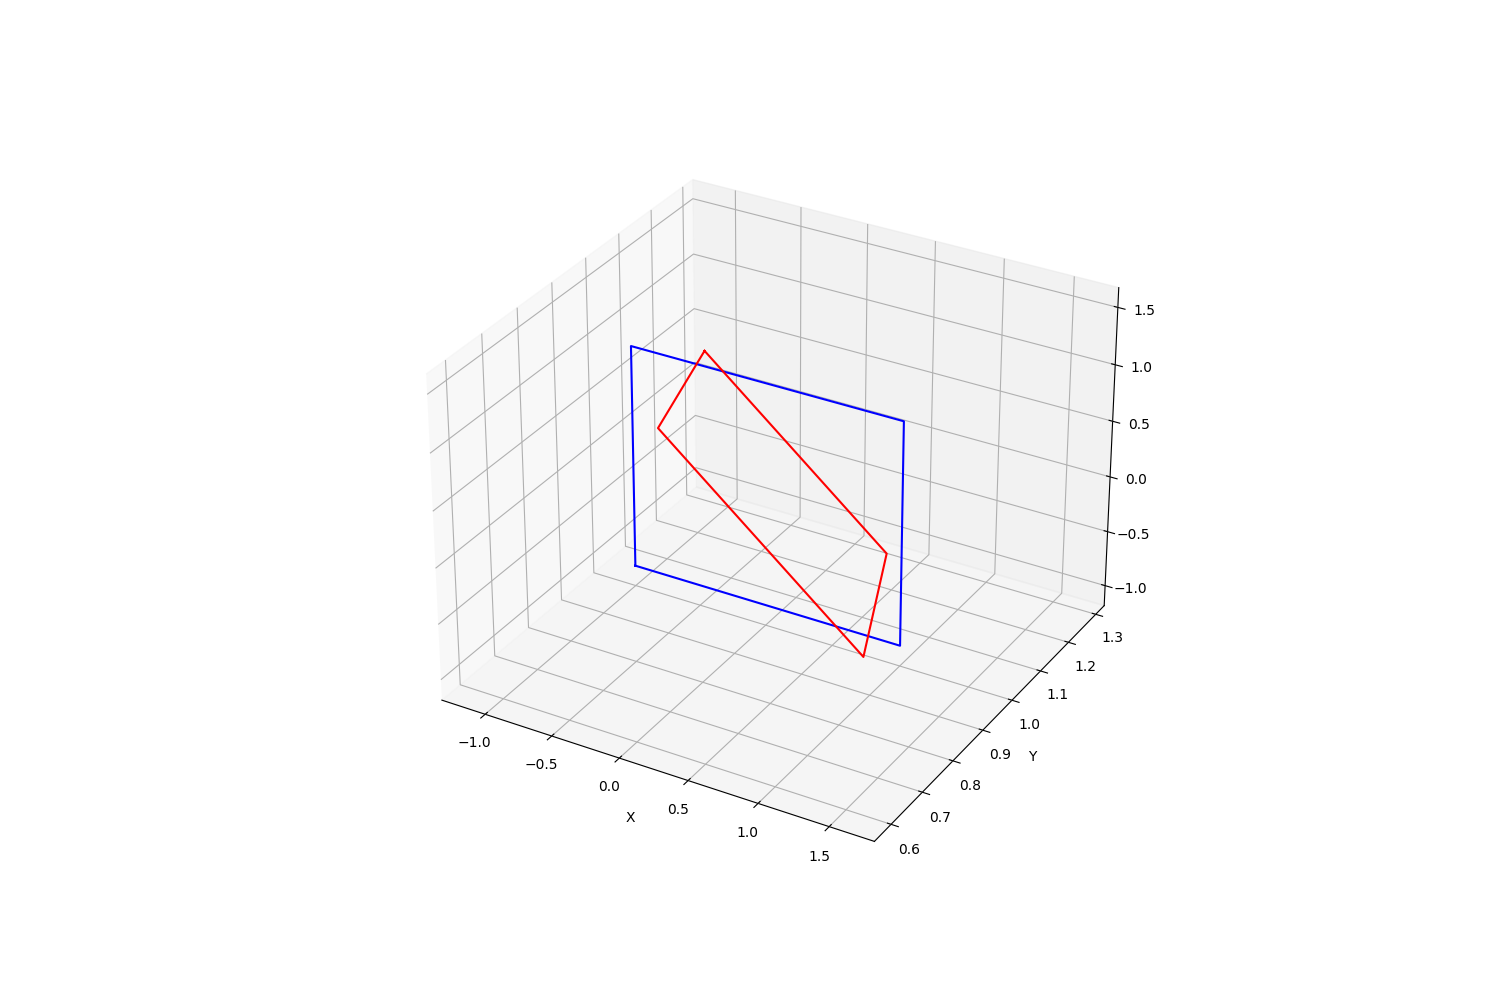

In [19]:
ax = plot_3D_setup()
P.plot(ax, color='b')
Q.plot(ax, color='r')

In [ ]:
import cvxpy as cp